# Introduction to Event Files

We can think of the NICER telescope as a giant X-ray photon bucket sitting on the ISS. It's job is to detect X-ray photons and measure their arrival time and energy. 

Each photon is called an event. After data reduction, most analysis will involve an 'event file' in some capacity. These event files, with extension '.evt', contain a table giving the arrivial time, energy, and other information about each detected photon. 

In this example we show how to read in an event file corresponding to ~2 years of PSR B1937+21 observations and construct a pulse profile. 

In [7]:
import datetime
import matplotlib.pyplot as plt

from astropy.table import Table

Our main tool will be the astropy table. Under the hood, an events file is a FITS file. This means it uses header/data units (HDUs) to store the information. The 0th HDU doesn't contain a table. Let's read in the first HDU with Table.read

In [8]:
tab = Table.read('1937_events.evt', hdu=1)
tab

TIME,RAWX,RAWY,PHA,PHA_FAST,DET_ID,DEADTIME,EVENT_FLAGS [8],TICK,MPU_A_TEMP,MPU_UNDER_COUNT,PI_FAST,PI,PI_RATIO,PULSE_PHASE
s,pix,pix,chan,chan,,s,,,Celsius,,chan,chan,,
float64,uint8,uint8,int16,int16,uint8,float64,bool,int64,float64,int32,int16,int16,float32,float64
110092734.163869113,4,6,658,--,30,0.000015195,False .. False,27372793382573,35.488,2,--,132,nan,0.25150223076343536
110092736.183132783,4,6,375,--,30,0.000015195,False .. False,27372845486617,35.488,2,--,31,nan,0.5164873450994492
110092736.588509619,4,0,590,537,17,0.000022637,False .. False,27376866386826,34.321,2,78,87,1.1153846,0.7478716820478439
110092737.984718546,2,0,668,--,37,0.000015195,False .. False,27372891973812,35.488,2,--,103,nan,0.04323413968086243
110092741.398286685,1,1,1771,1676,46,0.000022637,False .. False,27370028937001,33.579,3,533,532,0.9981238,0.3808726817369461
110092742.323651791,0,5,1639,1564,63,0.000022637,False .. False,27366372949450,32.201,5,473,474,1.0021142,0.41832685470581055
110092743.048320368,7,5,2959,2764,1,0.000022637,False .. False,27379491145885,33.579,2,970,1005,1.0360825,0.6187706142663956
110092745.029541537,7,3,1175,1115,3,0.000022637,False .. False,27379542268410,33.473,2,304,313,1.0296053,0.46219660341739655


We printed the table above, and we can see that it contains a TON of rows, with each row corresponding to a photon. We have the time of arrival on the leftmost column. It's formatted as seconds from some "time-zero". I'll get back to that later. 

What other columns are interesting? Well, PI stands for pulse intensity, or energy. The units are slightly weird. For a given PI value, say 500, we can divide by 100 to get keV. So PI=500 means the photon had 5keV of energy.

For this event file, we've already calculated the pulse phase. So we have a PULSE_PHASE column all the way on the right. This gives the phase of the pulsar with our timing model from 0 to 1. This is what we will use to make a profile.

Before we do so, it is worth exploring what else is in the EVT. The meta-data contains other information about the observation. Here, we've merged a bunch of obsIDs. This process doesn't always keep track of the meta data correctly, but we'll still use it as an example. First, print the meta data, which stored as an ordered dictionary

In [9]:
tab.meta

OrderedDict([('EXTNAME', 'EVENTS'),
             ('HDUCLASS', 'OGIP'),
             ('HDUCLAS1', 'EVENTS'),
             ('DATAMODE', 'PHOTON'),
             ('DATE', '2018-03-04T00:29:35'),
             ('EXPOSURE', 834312),
             ('ONTIME', 834312),
             ('TIMEPIXR', 0.0),
             ('TIMEDEL', 4e-08),
             ('TIMEZERO', -1.0),
             ('TLMIN2', 0),
             ('TLMAX2', 7),
             ('TLMIN3', 0),
             ('TLMAX3', 6),
             ('TLMIN4', 0),
             ('TLMAX4', 4095),
             ('TLMIN5', 0),
             ('TLMAX5', 4095),
             ('TLMIN7', 3.101e-07),
             ('TLMAX7', 7.90755e-05),
             ('comments',
              ['  DEADTIME is approximate MPU deadtime on a per-event basis. Each MPU',
               '  is independent of the others.  MPU dead-time is quantized in steps',
               '  of 620.2 ns.  True dead time may be anywhere within this step, but',
               '  this FITS file records the center

Two of the most useful things will be the date and exposure of the observation. Let's print those:

In [10]:
#Most useful things in meta is exposure and date

print(tab.meta['DATE'])
print(tab.meta['EXPOSURE'])

2018-03-04T00:29:35
834312


We saw that the table gives time in seconds with some huge number. What's time zero? Well, it turns out its January 1st, 2014. (Reference: https://heasarc.gsfc.nasa.gov/docs/nicer/mission_guide/)

We can use date time objects to convert

In [11]:
def convert_time(time):
    timezero = datetime.datetime(year=2014, month=1,
                                 day=1, hour=0, minute=0, second=0)
    new_time = timezero+datetime.timedelta(seconds=time)

    return new_time


In [12]:
time_example = convert_time(142039018.640167803)
print(time_example)

2018-07-02 23:16:58.640168


Back to the pulse profile. We have a table with the phases of all of our photons. A pulse profile, sometimes known as a light curve, shows the distribution of these phases. Let's make a histogram with matplotlib

Try changing the bins to see how the two pulses become easier/harder to identify.

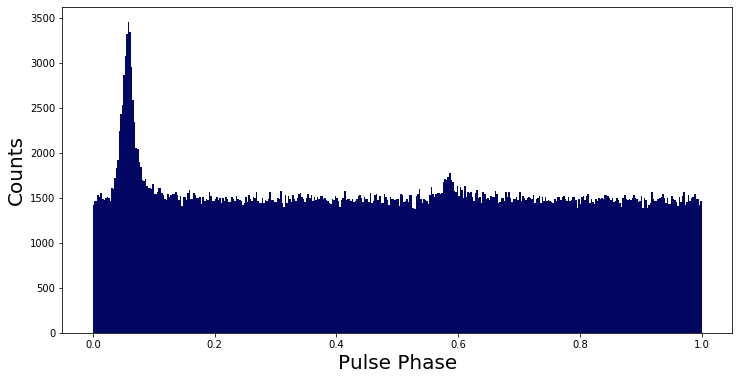

In [16]:
phases = tab['PULSE_PHASE'] #Access the correct column of the evt table

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(phases, bins=400, color='xkcd:darkblue')
ax.set_ylabel("Counts", fontsize=20)
ax.set_xlabel("Pulse Phase", fontsize=20)
plt.show()